Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


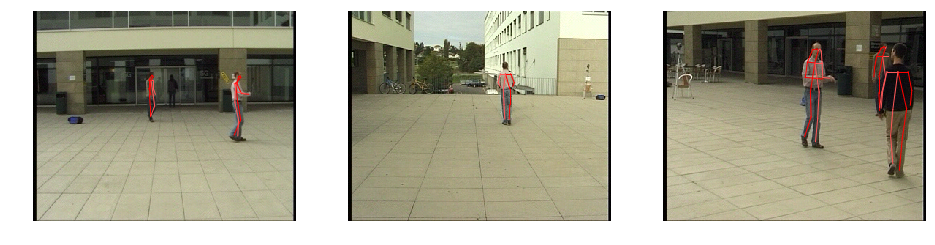

In [1]:
%matplotlib inline

import json
Settings = json.load(open('../settings.txt'))
import matplotlib.pyplot as plt
import numpy as np
from os.path import join
from cselect import color as cs
import sys
sys.path.insert(0,'../')
sys.path.insert(0,'../samples')
sys.path.insert(0,'../debugging')
from mvpose.data import epfl_campus
from time import time

root = Settings['data_root']
root = join(root, 'pak')
tmp = Settings['tmp']

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp

import mvpose.data.kth_football2 as kth
from mvpose import pose
from mvpose.settings import get_settings
from paf_loader import Loader
from mvpose.evaluation import pcp
from mvpose.plot.limbs import draw_mscoco_human, draw_mscoco_human2d

from openpose import OpenPose

FRAME = 660
pe = OpenPose(tmp=tmp, peak_threshold=0.05)
Im, Y, Calib = epfl_campus.get(root, FRAME)
predictions = pe.predict(Im, 'cvpr_campus', FRAME)


fig = plt.figure(figsize=(16, 8))
for idx, (im, pred) in enumerate(zip(Im, predictions)):
    ax = fig.add_subplot(1, 3, idx+1); ax.axis('off')
    ax.imshow(im)
    
    for human in pred:
        draw_mscoco_human2d(ax, human[:, 0:2], color='red')

plt.show()

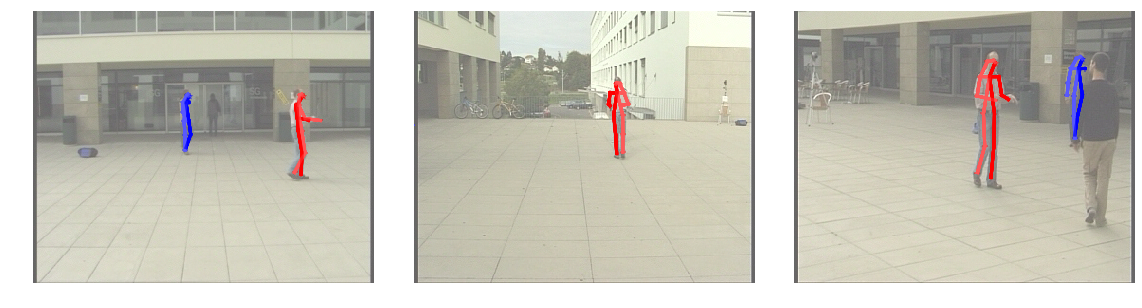

In [2]:
from mvpose.baseline.baseline import estimate

H = estimate(Calib, predictions, 
             epi_threshold=20,
             scale_to_mm=1000)

fig = plt.figure(figsize=(16,12))

colors = ['red', 'blue', 'green', 'teal']

for cid, cam in enumerate(Calib):
    ax = fig.add_subplot(1, 3, 1+cid)
    ax.axis('off')
    im = Im[cid]
    h,w,_ = im.shape
    ax.set_xlim([0, w])
    ax.set_ylim([h, 0])
    ax.imshow(im, alpha=0.6)
    
    for pid, hyp in enumerate(H):
        draw_mscoco_human(ax, hyp, cam, alpha=0.5,
                          color=colors[pid], linewidth=3)
    
plt.tight_layout()
plt.show()

In [3]:
valid_frames = list(range(350, 470)) + list(range(650, 750))

Calib = []
poses_per_frame = []
Pos3d = {}

_start = time()
for frame in valid_frames:
    print('frame', frame)
    Im, Y, calib = epfl_campus.get(root, frame)
    Calib.append(calib)
    Pos3d[frame] = Y
    predictions = pe.predict(Im, 'cvpr_campus', frame)
    poses_per_frame.append(predictions)
_end = time()
print('elapsed', _end - _start)

frame 350
frame 351
frame 352
frame 353
frame 354
frame 355
frame 356
frame 357
frame 358
frame 359
frame 360
frame 361
found = 2
frame 362
frame 363
frame 364
found = 2
frame 365
frame 366
frame 367
frame 368
found = 2
frame 369
frame 370
frame 371
frame 372
frame 373
frame 374
frame 375
frame 376
frame 377
found = 2
frame 378
frame 379
frame 380
frame 381
frame 382
frame 383
frame 384
frame 385
frame 386
frame 387
frame 388
frame 389
frame 390
frame 391
frame 392
frame 393
frame 394
frame 395
found = 2
frame 396
found = 2
frame 397
frame 398
found = 2
frame 399
found = 2
frame 400
frame 401
frame 402
frame 403
frame 404
frame 405
frame 406
frame 407
frame 408
found = 2
frame 409
frame 410
frame 411
frame 412
found = 2
frame 413
frame 414
found = 2
frame 415
found = 2
found = 2
frame 416
found = 2
frame 417
frame 418
found = 2
frame 419
found = 2
frame 420
found = 2
frame 421
found = 2
frame 422
found = 2
frame 423
found = 2
frame 424
frame 425
found = 2
frame 426
found = 2
frame 427


In [4]:
from mvpose.baseline.tracking import tracking, Track

_start = time()
tracks = tracking(Calib, poses_per_frame,
                  epi_threshold=20,
                  scale_to_mm=1000,
                  max_distance_between_tracks=200,
                  actual_frames=valid_frames,
                  min_track_length=10,
                  merge_distance=80,
                  last_seen_delay=5)
_end = time()
print('elapsed', _end - _start)

print("#tracks", len(tracks))

for track in tracks:
    print(len(track))
    
_start = time()
tracks_ = []
for track in tracks:
    track = Track.smoothing(track, 
                            sigma=1.7,
                            interpolation_range=50)
    tracks_.append(track)
tracks = tracks_
_end = time()
print("elapsed", _end - _start)

elapsed 3.489621639251709
#tracks 8
100
75
16
100
17
13
73
68
elapsed 0.09345865249633789


In [5]:
# =====================================================
def proper_pcp_calc(Y, Humans):
    alpha = 0.5
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs

PER_GTID = {}
for frame in valid_frames:
    Humans = []
    for track in tracks:
        pose = track.get_by_frame(frame)
        if pose is not None:
            Humans.append(pose)
    Humans = kth.transform3d_from_mscoco(Humans)
    
    print("Humans " + str(frame), len(Humans))
    
    Y = Pos3d[frame]
    L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = proper_pcp_calc(Y, Humans) 
    if len(L_Arms) > 0:
        for gtid, larms, uarms, llegs, ulegs in zip(
            GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
        ):
            if not gtid in PER_GTID:
                PER_GTID[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            PER_GTID[gtid]['larms'].append(larms)
            PER_GTID[gtid]['uarms'].append(uarms)
            PER_GTID[gtid]['llegs'].append(llegs)
            PER_GTID[gtid]['ulegs'].append(ulegs)
            PER_GTID[gtid]['frame'].append(frame)

Humans 350 8
Humans 351 1
Humans 352 1
Humans 353 1
Humans 354 1
Humans 355 1
Humans 356 1
Humans 357 1
Humans 358 1
Humans 359 1
Humans 360 1
Humans 361 1
Humans 362 1
Humans 363 1
Humans 364 1
Humans 365 1
Humans 366 1
Humans 367 1
Humans 368 1
Humans 369 1
Humans 370 1
Humans 371 1
Humans 372 1
Humans 373 1
Humans 374 1
Humans 375 1
Humans 376 1
Humans 377 1
Humans 378 1
Humans 379 1
Humans 380 1
Humans 381 1
Humans 382 1
Humans 383 1
Humans 384 1
Humans 385 1
Humans 386 1
Humans 387 1
Humans 388 1
Humans 389 1
Humans 390 1
Humans 391 1
Humans 392 1
Humans 393 1
Humans 394 1
Humans 395 2
Humans 396 2
Humans 397 2
Humans 398 2
Humans 399 2
Humans 400 2
Humans 401 2
Humans 402 2
Humans 403 2
Humans 404 2
Humans 405 2
Humans 406 2
Humans 407 2
Humans 408 2
Humans 409 2
Humans 410 2
Humans 411 2
Humans 412 2
Humans 413 2
Humans 414 2
Humans 415 2
Humans 416 2
Humans 417 2
Humans 418 2
Humans 419 2
Humans 420 2
Humans 421 2
Humans 422 2
Humans 423 2
Humans 424 2
Humans 425 2
Humans 426 2

In [6]:
total_avg = []
for key, values in PER_GTID.items():
    print('actor ', key)
    print('\tuarms:', np.mean(values['uarms']))
    print('\tlarms:', np.mean(values['larms']))
    print('\tulegs:', np.mean(values['ulegs']))
    print('\tllegs:', np.mean(values['llegs']))
    avg = np.mean([
        np.mean(values['uarms']),
        np.mean(values['larms']),
        np.mean(values['ulegs']),
        np.mean(values['llegs'])
    ])
    total_avg.append(avg)
    print('\tavg:  ', avg)
print('\navg*:  ', np.mean(total_avg))

actor  1
	uarms: 0.9893617021276596
	larms: 0.6037234042553191
	ulegs: 0.9893617021276596
	llegs: 0.9893617021276596
	avg:   0.8929521276595745
actor  2
	uarms: 0.9485294117647058
	larms: 0.6764705882352942
	ulegs: 0.9852941176470589
	llegs: 0.9852941176470589
	avg:   0.8988970588235294
actor  0
	uarms: 0.78125
	larms: 0.4166666666666667
	ulegs: 0.9791666666666666
	llegs: 0.9791666666666666
	avg:   0.7890625

avg*:   0.860303895494368


In [7]:
# no smoothing
# actor  1
# 	uarms: 0.9920212765957447
# 	larms: 0.5558510638297872
# 	ulegs: 0.9946808510638298
# 	llegs: 0.9946808510638298
# 	avg:   0.8843085106382979
# actor  2
# 	uarms: 0.8272058823529411
# 	larms: 0.5992647058823529
# 	ulegs: 0.9926470588235294
# 	llegs: 0.9926470588235294
# 	avg:   0.8529411764705882
# actor  0
# 	uarms: 0.59375
# 	larms: 0.4479166666666667
# 	ulegs: 1.0
# 	llegs: 1.0
# 	avg:   0.7604166666666667

# avg*:   0.8325554512585175

In [8]:
# =====================================
def generate_pcp_score(frame):
    global pe
    alpha = 0.5
    Im, Y, Calib = epfl_campus.get(root, frame)
    predictions = pe.predict(Im, 'cvpr_campus', frame)
    detections = estimate(Calib, predictions, epi_threshold=10)
    Humans = kth.transform3d_from_mscoco(detections)
    
    L_Arms = []
    U_Arms = []
    L_Legs = []
    U_Legs = []
    GTIDs = []
  
    for gtid, gt in enumerate(Y):
        if gt is None:
            continue
        
        larms = 0
        uarms = 0
        llegs = 0
        ulegs = 0
        avg = 0
        for d in Humans:
            r = pcp.evaluate(gt, d, alpha)
            larms_ = r.lower_arms
            uarms_ = r.upper_arms
            ulegs_ = r.upper_legs
            llegs_ = r.lower_legs
            avg_ = (larms_ + uarms_ + ulegs_ + llegs_) / 4
            if avg_ > avg:
                avg = avg_
                larms = larms_
                uarms = uarms_
                llegs = llegs_
                ulegs = ulegs_
        
        L_Arms.append(larms)
        U_Arms.append(uarms)
        L_Legs.append(llegs)
        U_Legs.append(ulegs)
        GTIDs.append(gtid)
    
    return L_Arms, U_Arms, L_Legs, U_Legs, GTIDs

# =====================================

valid_frames = list(range(350, 470)) + list(range(650, 750))
PER_GTID = {}

for frame in valid_frames:
    _start = time()
    L_Arms, U_Arms, L_Legs, U_Legs, GTIDs = generate_pcp_score(frame)
    _end = time()
    print('frame ' + str(frame) + ', elapsed:', _end - _start)
    
    if len(L_Arms) > 0:
        for gtid, larms, uarms, llegs, ulegs in zip(
            GTIDs, L_Arms, U_Arms, L_Legs, U_Legs
        ):
            if not gtid in PER_GTID:
                PER_GTID[gtid] = {
                    'larms': [],
                    'uarms': [],
                    'llegs': [],
                    'ulegs': [],
                    'frame': []
                }
            PER_GTID[gtid]['larms'].append(larms)
            PER_GTID[gtid]['uarms'].append(uarms)
            PER_GTID[gtid]['llegs'].append(llegs)
            PER_GTID[gtid]['ulegs'].append(ulegs)
            PER_GTID[gtid]['frame'].append(frame)
    

frame 350, elapsed: 0.23467540740966797
frame 351, elapsed: 0.15396833419799805
frame 352, elapsed: 0.16839170455932617
frame 353, elapsed: 0.15716814994812012
frame 354, elapsed: 0.15606164932250977
frame 355, elapsed: 0.15543222427368164
frame 356, elapsed: 0.22379112243652344
frame 357, elapsed: 0.43180274963378906
frame 358, elapsed: 0.1395418643951416
frame 359, elapsed: 0.3857407569885254
frame 360, elapsed: 0.17665648460388184
frame 361, elapsed: 0.40825414657592773
frame 362, elapsed: 0.4567983150482178
frame 363, elapsed: 0.32567691802978516
frame 364, elapsed: 0.6075072288513184
frame 365, elapsed: 0.246856689453125
frame 366, elapsed: 0.15208649635314941
frame 367, elapsed: 0.7606518268585205
frame 368, elapsed: 0.2919280529022217
frame 369, elapsed: 0.19778132438659668
frame 370, elapsed: 0.18004941940307617
frame 371, elapsed: 0.15467500686645508
frame 372, elapsed: 0.16253352165222168
frame 373, elapsed: 0.1511235237121582
frame 374, elapsed: 0.1627180576324463
frame 375,

frame 738, elapsed: 0.17578411102294922
frame 739, elapsed: 0.16701340675354004
frame 740, elapsed: 0.18109607696533203
frame 741, elapsed: 0.1959686279296875
frame 742, elapsed: 0.19041967391967773
frame 743, elapsed: 0.18631386756896973
frame 744, elapsed: 0.1871321201324463
frame 745, elapsed: 0.1785588264465332
frame 746, elapsed: 0.18271684646606445
frame 747, elapsed: 0.17856097221374512
frame 748, elapsed: 0.18232417106628418
frame 749, elapsed: 0.1879570484161377


In [9]:
total_avg = []
for key, values in PER_GTID.items():
    print('actor ', key)
    print('\tuarms:', np.mean(values['uarms']))
    print('\tlarms:', np.mean(values['larms']))
    print('\tulegs:', np.mean(values['ulegs']))
    print('\tllegs:', np.mean(values['llegs']))
    avg = np.mean([
        np.mean(values['uarms']),
        np.mean(values['larms']),
        np.mean(values['ulegs']),
        np.mean(values['llegs'])
    ])
    total_avg.append(avg)
    print('\tavg:  ', avg)
print('\navg*:  ', np.mean(total_avg))

actor  1
	uarms: 0.0
	larms: 0.0
	ulegs: 0.0
	llegs: 0.0
	avg:   0.0
actor  2
	uarms: 0.0
	larms: 0.0
	ulegs: 0.0
	llegs: 0.0
	avg:   0.0
actor  0
	uarms: 0.0
	larms: 0.0
	ulegs: 0.0
	llegs: 0.0
	avg:   0.0

avg*:   0.0
